# **To reproduce study results use cellrank required package versions**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.9.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0rc0 pynndescent==0.5.4


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

In [3]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.7.6) on 2022-08-17 12:54.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


### **Read in loom adata and select for GABA neurons**

In [4]:
# loom adata from 17__loom-file-preprocessing.ipynb
loom_file_nm = "../data/whole-tissue_with-looms.h5ad"
adata = sc.read( loom_file_nm)

### **Read in GABA cluster adata**

In [5]:
# gaba adata from 04__inhibitory-neu_clustering.ipynb
gaba_file_nm = "../data/post-gaba-clustering.h5ad"
gaba = sc.read( gaba_file_nm)

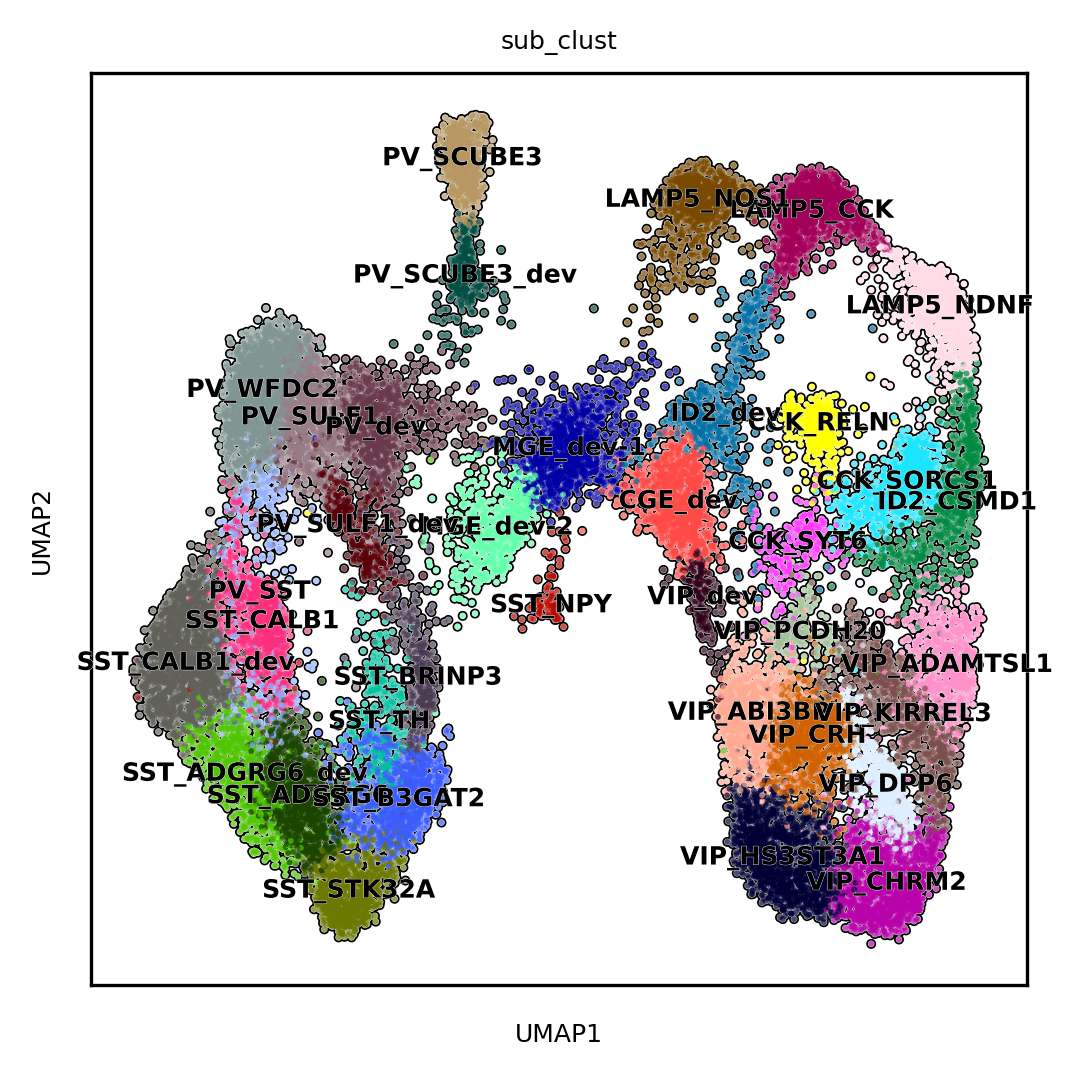

In [6]:
sc.settings.set_figure_params( dpi=150, fontsize=6)
sc.pl.embedding( gaba, basis='umap', color=['sub_clust'], legend_fontsize=6, add_outline=True, legend_loc='on data', size=8, legend_fontoutline=0.2)

### Find intersect of barcodes and match order of gaba to loom - we only want keep those cells that pass QC and were called a cell in loom processing

In [7]:
# adatas do not contain same nucs, so need to take intersect of barcodes (BCs) 
all_loom_mk  = nmc.member_test( adata.obs_names.values, gaba.obs_names.values)
pre_adata_mk = nmc.member_test( gaba.obs_names.values,  adata.obs_names.values)
adata = adata[all_loom_mk]
gaba = gaba[pre_adata_mk]
adata.shape, gaba.shape

((24898, 26747), (24898, 22583))

In [8]:
# need to match order of BCs to make sure (un)spliced cts get assigned to correct nucs
adata_bc_list = adata.obs_names.values.tolist()
gaba_bc_list  = gaba.obs_names.values.tolist()
# return adata args in loom BC order 
pre_to_loom_args = np.array([gaba_bc_list.index(ii) for ii in adata_bc_list])
gaba = gaba[pre_to_loom_args]

In [9]:
# check if order of BCs match, should sum to 0
(adata.obs_names.values!=gaba.obs_names.values).sum()

0

In [10]:
adata.obsm = gaba.obsm.copy()

## Format clusters and colors to match manuscript

In [11]:
def merge_dev( dev, mature, adata=adata):
    adata.obs['sub_clust'][adata.obs['sub_clust']==dev] = mature
    return

In [12]:
merge_dev( 'SST_CALB1_dev', 'SST_CALB1')
merge_dev( 'SST_ADGRG6_dev', 'SST_ADGRG6')
merge_dev( 'PV_SCUBE3_dev', 'PV_SCUBE3')
merge_dev( 'PV_SULF1_dev', 'PV_SULF1')
# since MGE_dev is not in sub_clust have to reset cat type to str
adata.obs['sub_clust'] = adata.obs['sub_clust'].astype(str)
merge_dev( 'MGE_dev-1', 'MGE_dev')
merge_dev( 'MGE_dev-2', 'MGE_dev')

In [13]:
color_dict = {'CCK_RELN':'#a8484d','CCK_SORCS1':'#18f3f0','CCK_SYT6':'#fffe03','CGE_dev':'#cd7c0a','CGE_ID2_dev':'#cd7c0a','ID2_CSMD1':'#17a715','ID2_dev':'#4c12e3',
              'LAMP5_NOS1':'#b2e993','LAMP5_CCK':'#ee0aad','LAMP5_NDNF':'#050156','MGE_dev':'#fefec0','PV_SCUBE3':'#3efb5c','PV_SST':'#6f0607',
              'PV_SULF1':'#6cadcb','PV_WFDC2':'#fb1916','PV_dev':'#f2ad5d','SST_ADGRG6':'#91c827','SST_B3GAT2':'#a84afa','SST_BRINP3':'#f995ef',
              'SST_CALB1':'#cc709b','SST_NPY':'#588064','SST_STK32A':'#703192','SST_TH':'#3a4725','VIP_ABI3BP':'#0b76a5','VIP_ADAMTSL1':'#93e3ff',
              'VIP_CHRM2':'#3b80fe','VIP_CRH':'#2ebb8e','VIP_DPP6':'#0a3ef2','VIP_HS3ST3A1':'#fd4a77','VIP_KIRREL3':'#d1ec39','VIP_PCDH20':'#5fed05',
              'VIP_dev':'#9c9b7d','the_rest': '#b0afae','Other': '#b0afae'}

In [14]:
adata.obs['plot'] = adata.obs['sub_clust'].astype(str)
adata.obs['plot'].loc[~adata.obs['sub_clust'].isin( ['MGE_dev','CGE_dev','ID2_dev','LAMP5_NOS1','LAMP5_CCK'])] = 'the_rest'

In [15]:
adata.uns['arcsinh_cofact'] = 0.55
adata.obs['arcsinh_age'] = np.arcsinh( adata.obs['numerical_age'].values / adata.uns['arcsinh_cofact'])

In [16]:
stage_order = adata.uns['stage_order']
for itr, s_itr in enumerate( stage_order):
    adata.obs.loc[adata.obs['stage_id']==s_itr,'stage_num'] = itr
adata.obs['stage_num'] = adata.obs['stage_num'].astype(float)
adata.obs['sub_clust'] = adata.obs['sub_clust'].astype(str)

# adata.obs.loc[adata.obs['sub_clust']=='ID2_dev','sub_clust'] = 'CGE_dev'
# adata.obs.loc[adata.obs['sub_clust'].isin(['MGE_dev-1','MGE_dev-2']),'sub_clust'] = 'MGE_dev'

In [17]:
for itr, s_itr in enumerate( stage_order):
    adata.obs.loc[adata.obs['stage_id']==s_itr,'stage_num'] = itr
adata.obs['stage_num'] = adata.obs['stage_num'].astype(float)
adata.obs['sub_clust'] = adata.obs['sub_clust'].astype(str)

# adata.obs.loc[adata.obs['sub_clust'].isin( ['CGE_dev', 'ID2_dev']),'sub_clust'] = 'CGE_ID2_dev'
# adata.obs['sub_clust'] = adata.obs['sub_clust'].astype('category')

## Compute cytotrace and connectivity kernels before scVelo operations

In [18]:
scv.settings.verbosity = 3
scv.set_figure_params('scvelo')  

def plot_kernel( adata):
    scv.pl.velocity_embedding_stream( adata, color="lightgrey", vkey="T_fwd", basis="umat", 
                                      legend_loc='none', figsize=(8,8), cmap='viridis',
                                      linewidth=3.0, arrow_style='->')
#                                   groups=['CGE_dev','MGE_dev','LAMP5_NOS1','LAMP5_CCK','ID2_dev'],
    return

In [19]:
# CytoTRACE by default uses imputed data - a simple way to compute KNN-imputed data is to use scVelo's moments
# function. However, note that this function expects `spliced` counts because it's designed for RNA velocity,
# so we're using a simple hack here:
# if 'spliced' not in adata.layers or 'unspliced' not in adata.layers:
adata.layers['loom_spliced'] = adata.layers['spliced'].copy()
adata.layers['loom_unspliced'] = adata.layers['unspliced'].copy()

adata.layers['spliced'] = adata.X.copy()
adata.layers['unspliced'] = adata.X.copy()

# scv.pp.neighbors( adata, n_neighbors=25, n_pcs=pcs)
# compute KNN-imputation using scVelo's moments function
scv.pp.moments( adata, n_pcs=303, n_neighbors=25)

from cellrank.tl.kernels import CytoTRACEKernel
ctk = CytoTRACEKernel( adata)
ctk.compute_transition_matrix( threshold_scheme="soft", nu=0.5, n_jobs=20)

adata.layers['spliced'] = adata.layers['loom_spliced']
adata.layers['unspliced'] = adata.layers['loom_unspliced']

computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:23) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24898/24898 [00:10<00:00, 2334.33cell/s]


In [20]:
ctk.compute_projection( basis="umat")

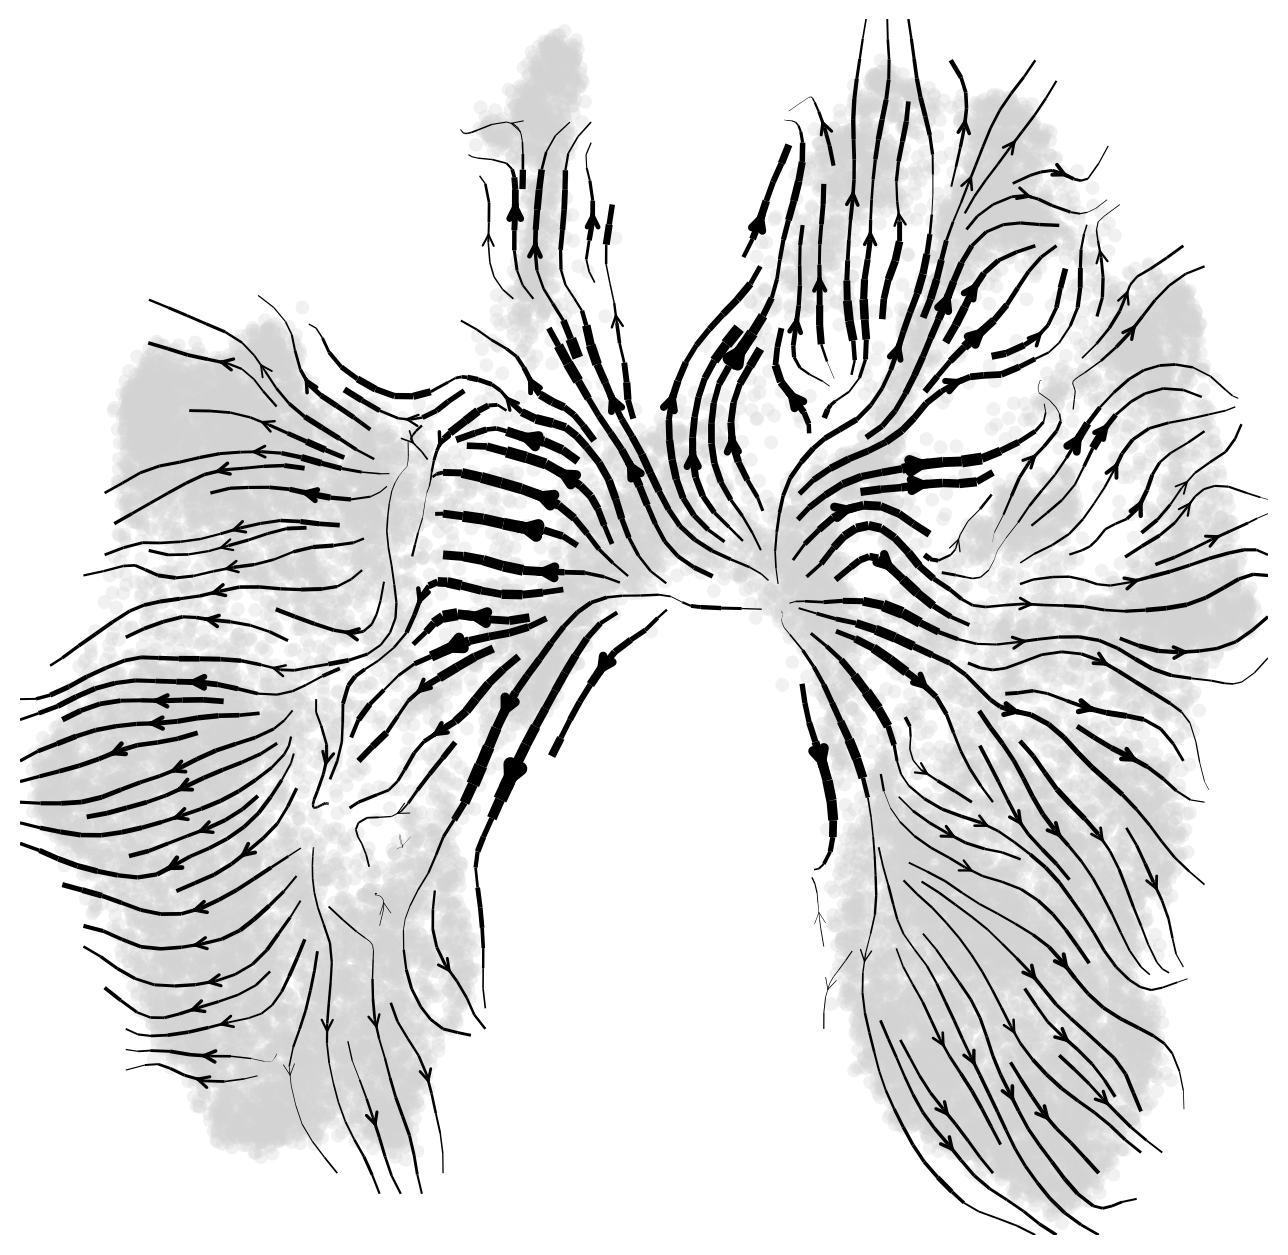

In [21]:
plot_kernel( adata)

In [22]:
c_dict = {'MGE_dev':'#fefec0', 'CGE_dev':  '#cd7c0a', 'the_rest': '#b0afae'}
c_dict

adata.obs['plot'] = adata.obs['sub_clust'].astype(str)
adata.obs['plot'].loc[~adata.obs['sub_clust'].isin( ['MGE_dev','CGE_dev','LAMP5_NOS1','LAMP5_CCK','LAMP5_NDNF'])] = 'Other'
adata.obs['plot'].value_counts()

Other         20066
MGE_dev        1310
LAMP5_CCK      1140
LAMP5_NDNF      862
LAMP5_NOS1      784
CGE_dev         736
Name: plot, dtype: int64

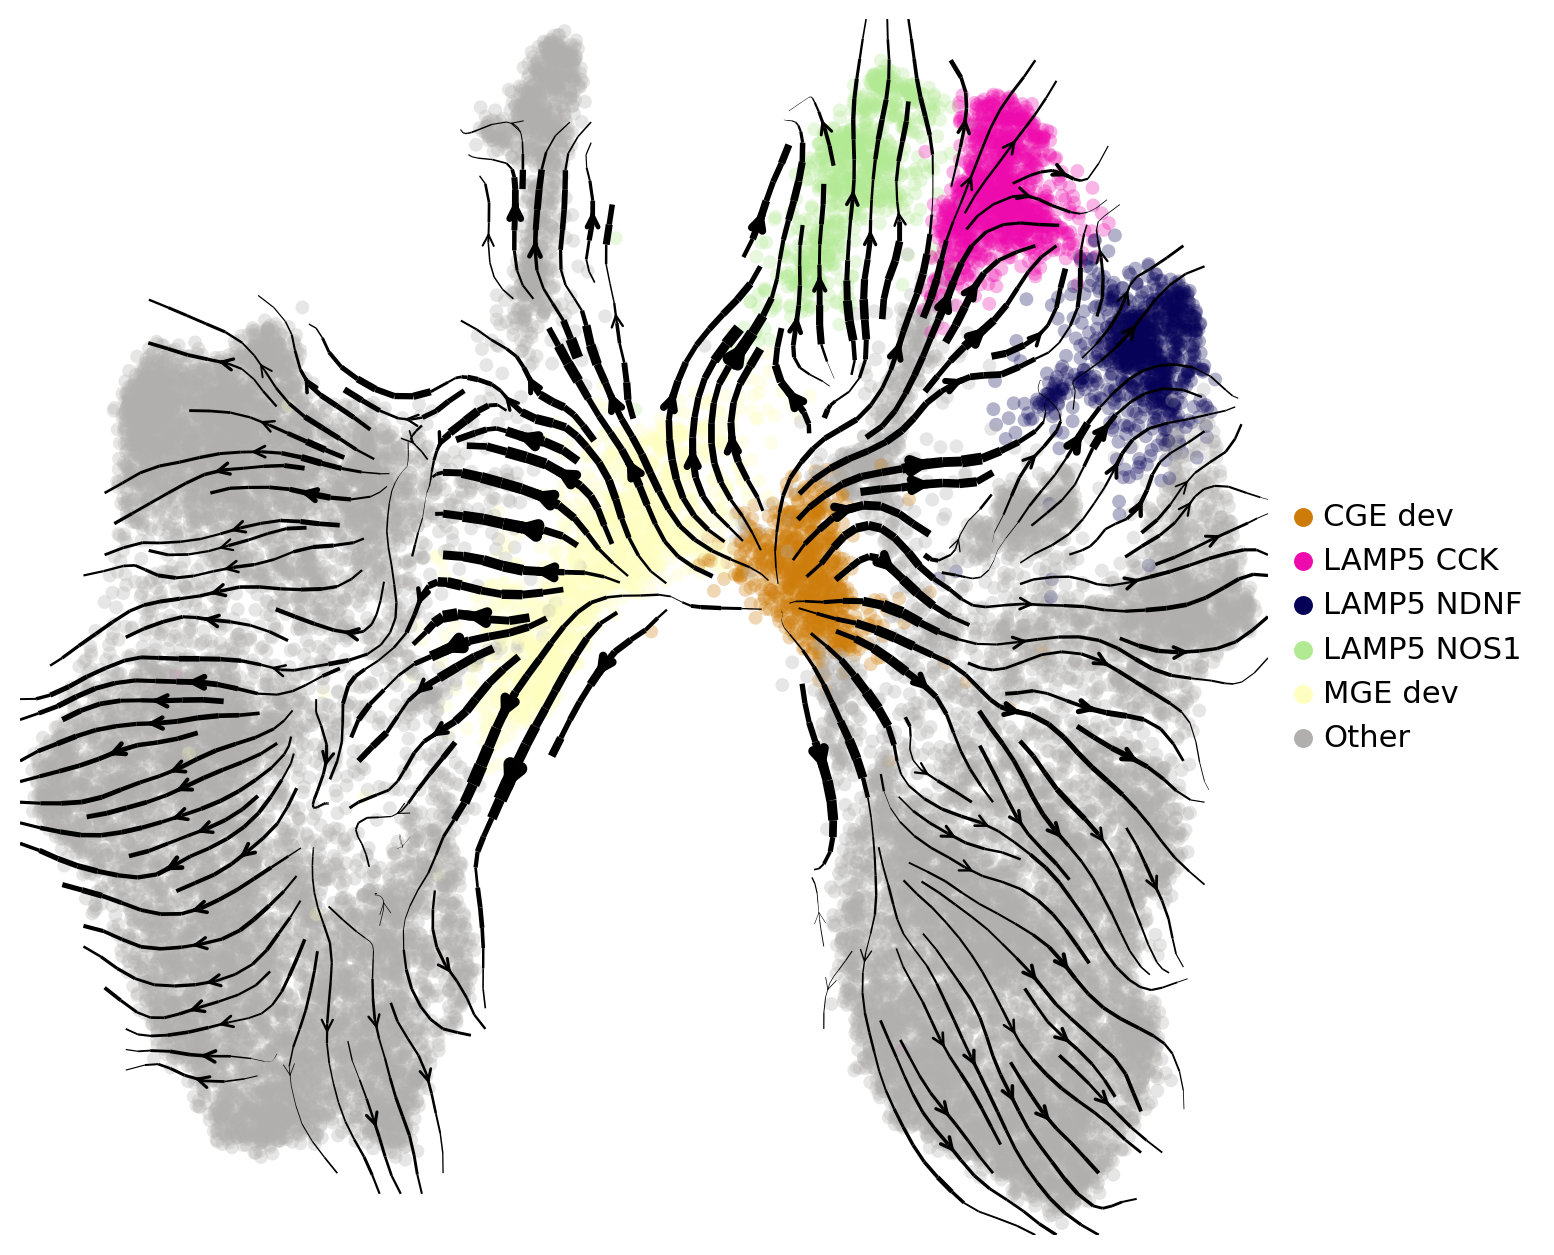

In [23]:
scv.pl.velocity_embedding_stream( adata, color="plot", vkey="T_fwd", basis="umat", 
                                      legend_loc='on right', figsize=(8,8), cmap='viridis',
                                      linewidth=3.0, arrow_style='->', palette=color_dict, title='')#, min_mass=10000)

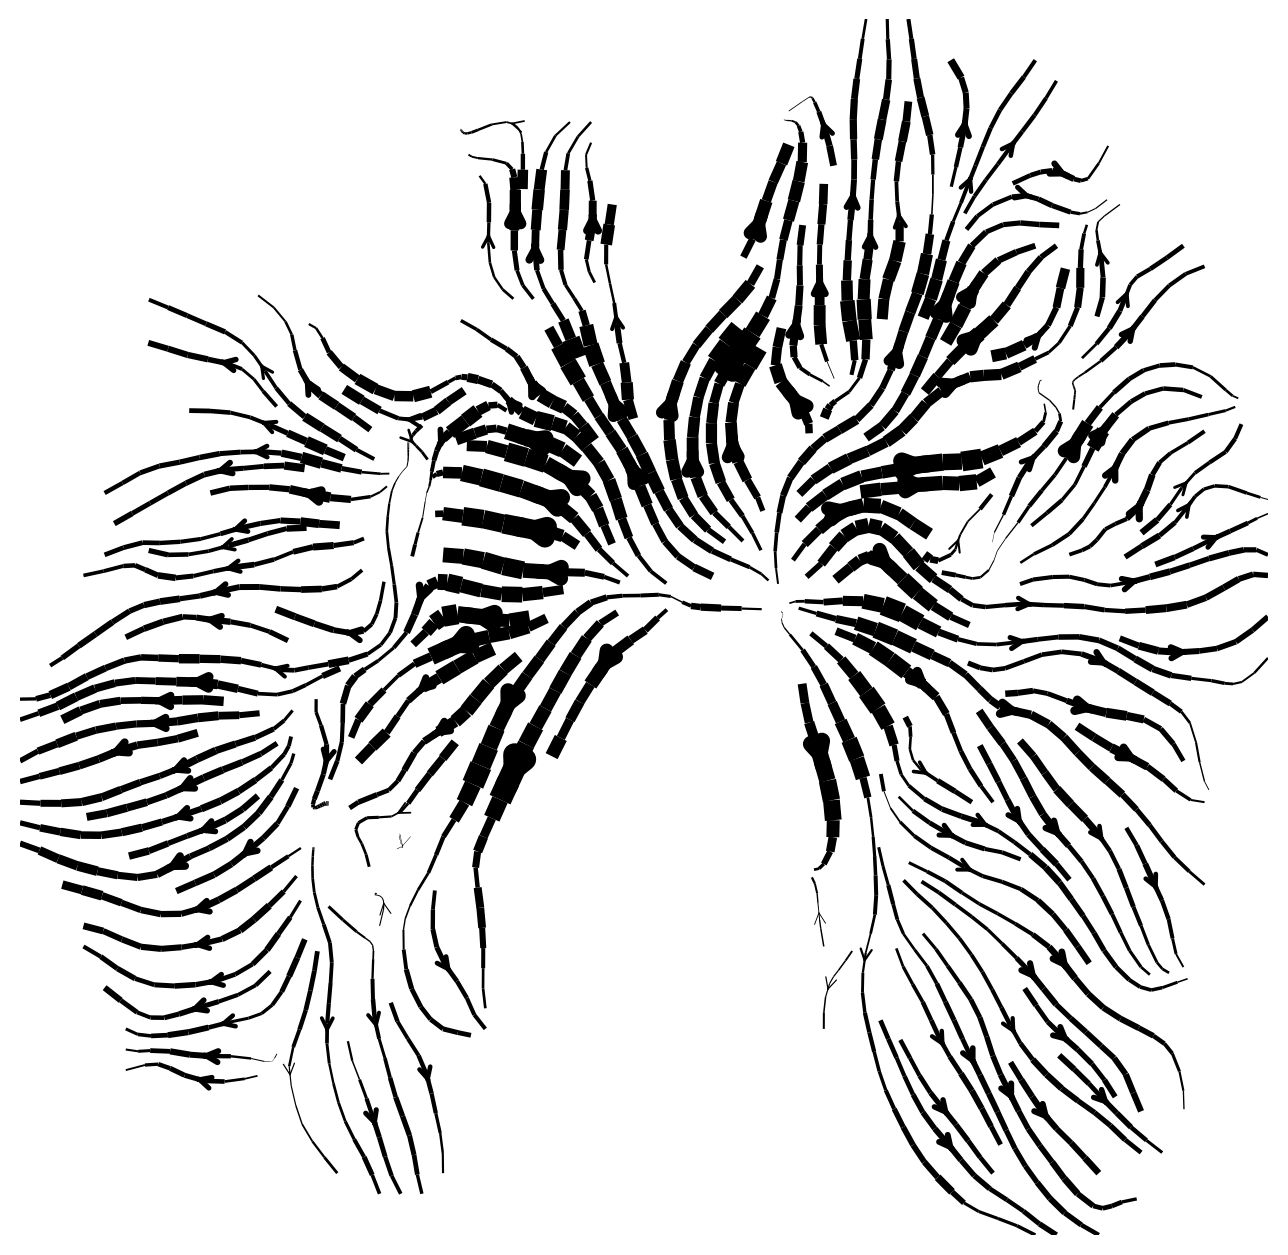

In [24]:
ax = scv.pl.velocity_embedding_stream( adata, basis='umat', color=['LightGrey'], 
                                      figsize=(8,8), alpha=0.2, size=0.0, vkey="T_fwd", 
                                      show=False, linewidth=5.0, arrow_style='->')

In [25]:
adata.obs['plot'] = adata.obs['major_clust'].astype(str)
adata.obs['plot'].loc[~adata.obs['major_clust'].isin( ['MGE_dev','CGE_dev'])] = 'the_rest'

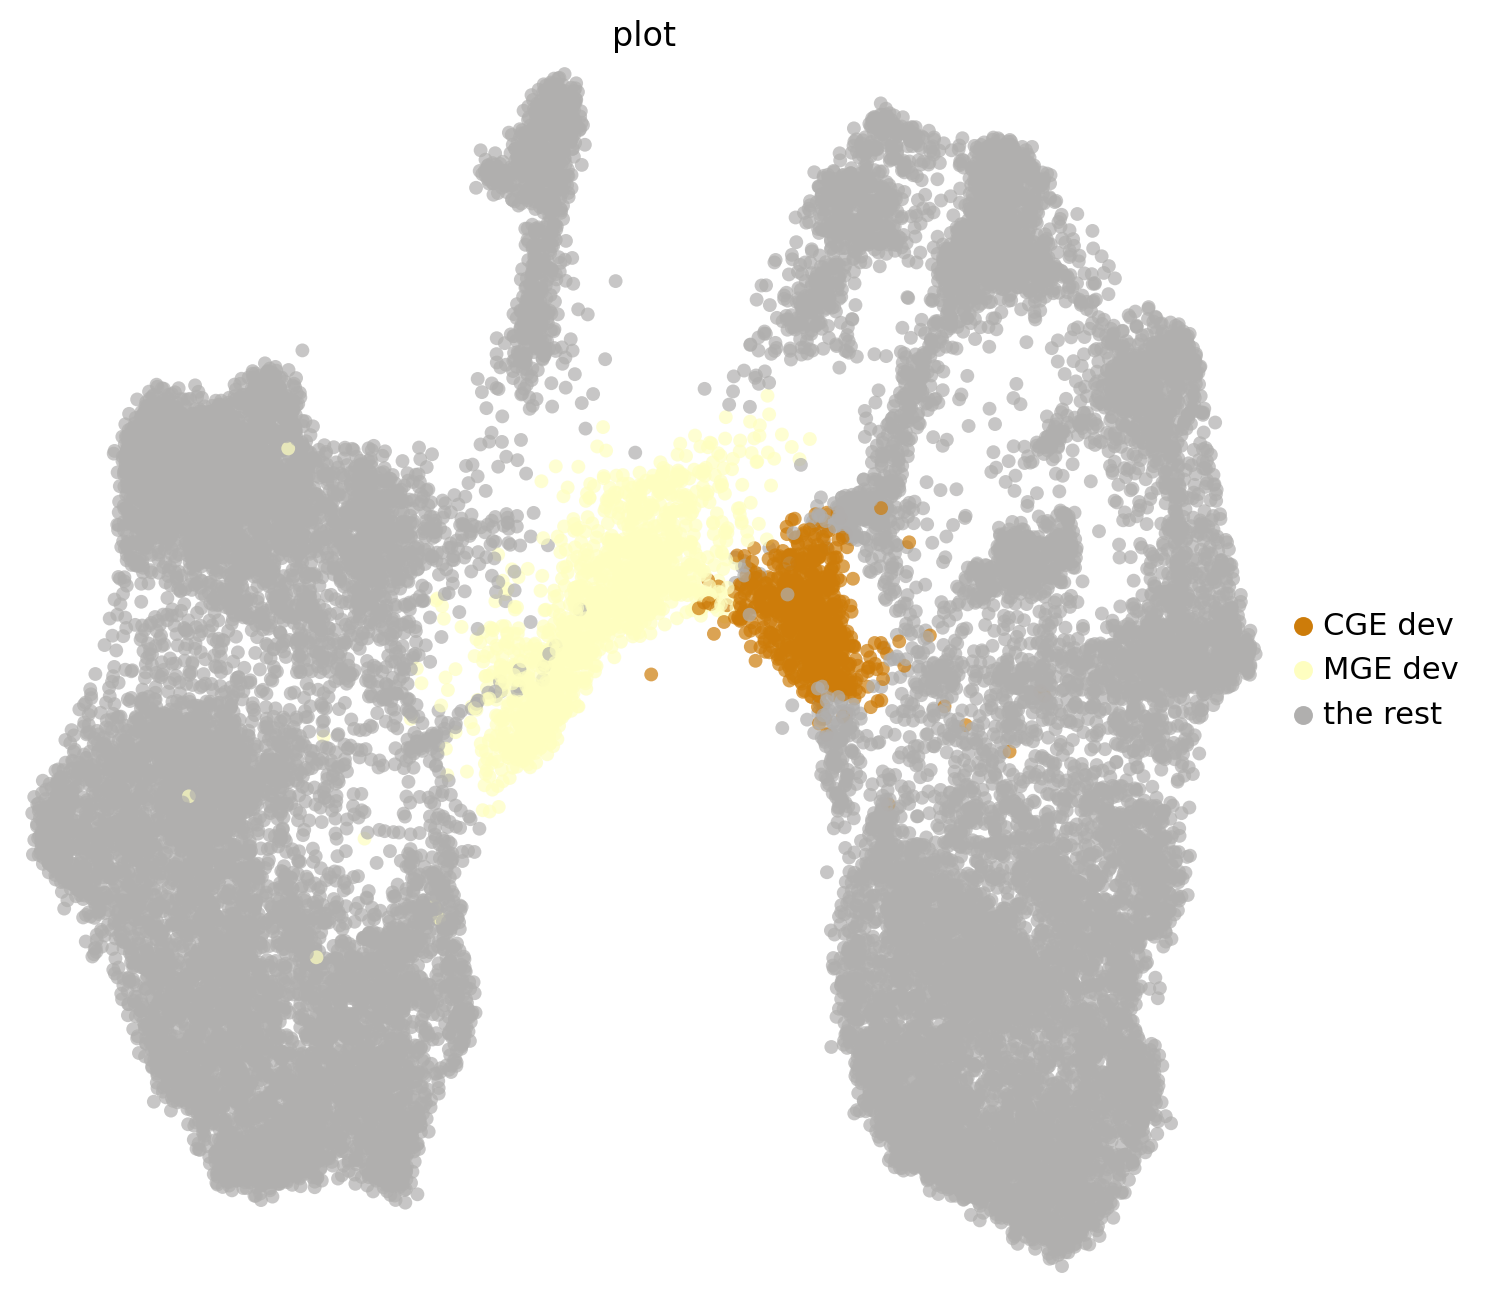

In [26]:
scv.pl.velocity_embedding_stream( adata, basis='umat', color=['plot'], figsize=(8,8), palette=color_dict, 
                                  vkey="T_fwd", min_mass=10000, alpha=0.7, legend_loc='on right')

In [27]:
adata.obs['sub_clust'] = adata.obs['sub_clust'].astype(str)
adata.obs.loc[adata.obs['sub_clust'].isin( ['CGE_dev', 'ID2_dev']),'sub_clust'] = 'CGE_ID2_dev'
adata.obs['sub_clust'] = adata.obs['sub_clust'].astype("category")

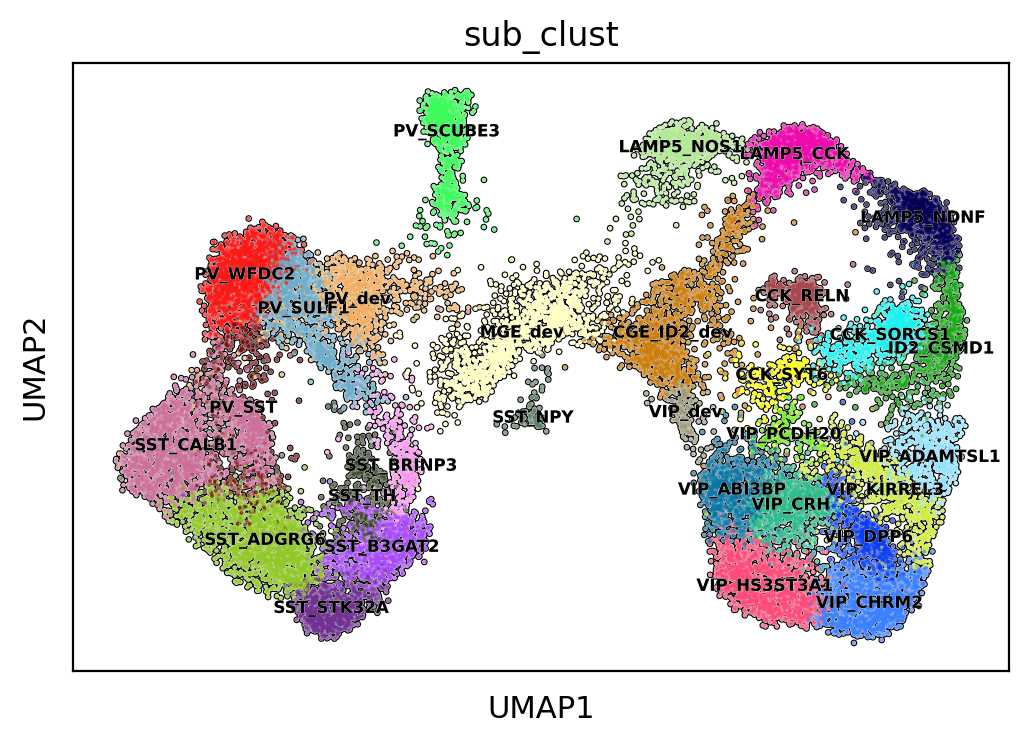

In [28]:
sc.pl.embedding( adata, basis='umap', color=['sub_clust'], legend_fontsize=6, add_outline=True, legend_loc='on data', size=8, legend_fontoutline=0.2, palette=color_dict)

## **Flow maps**

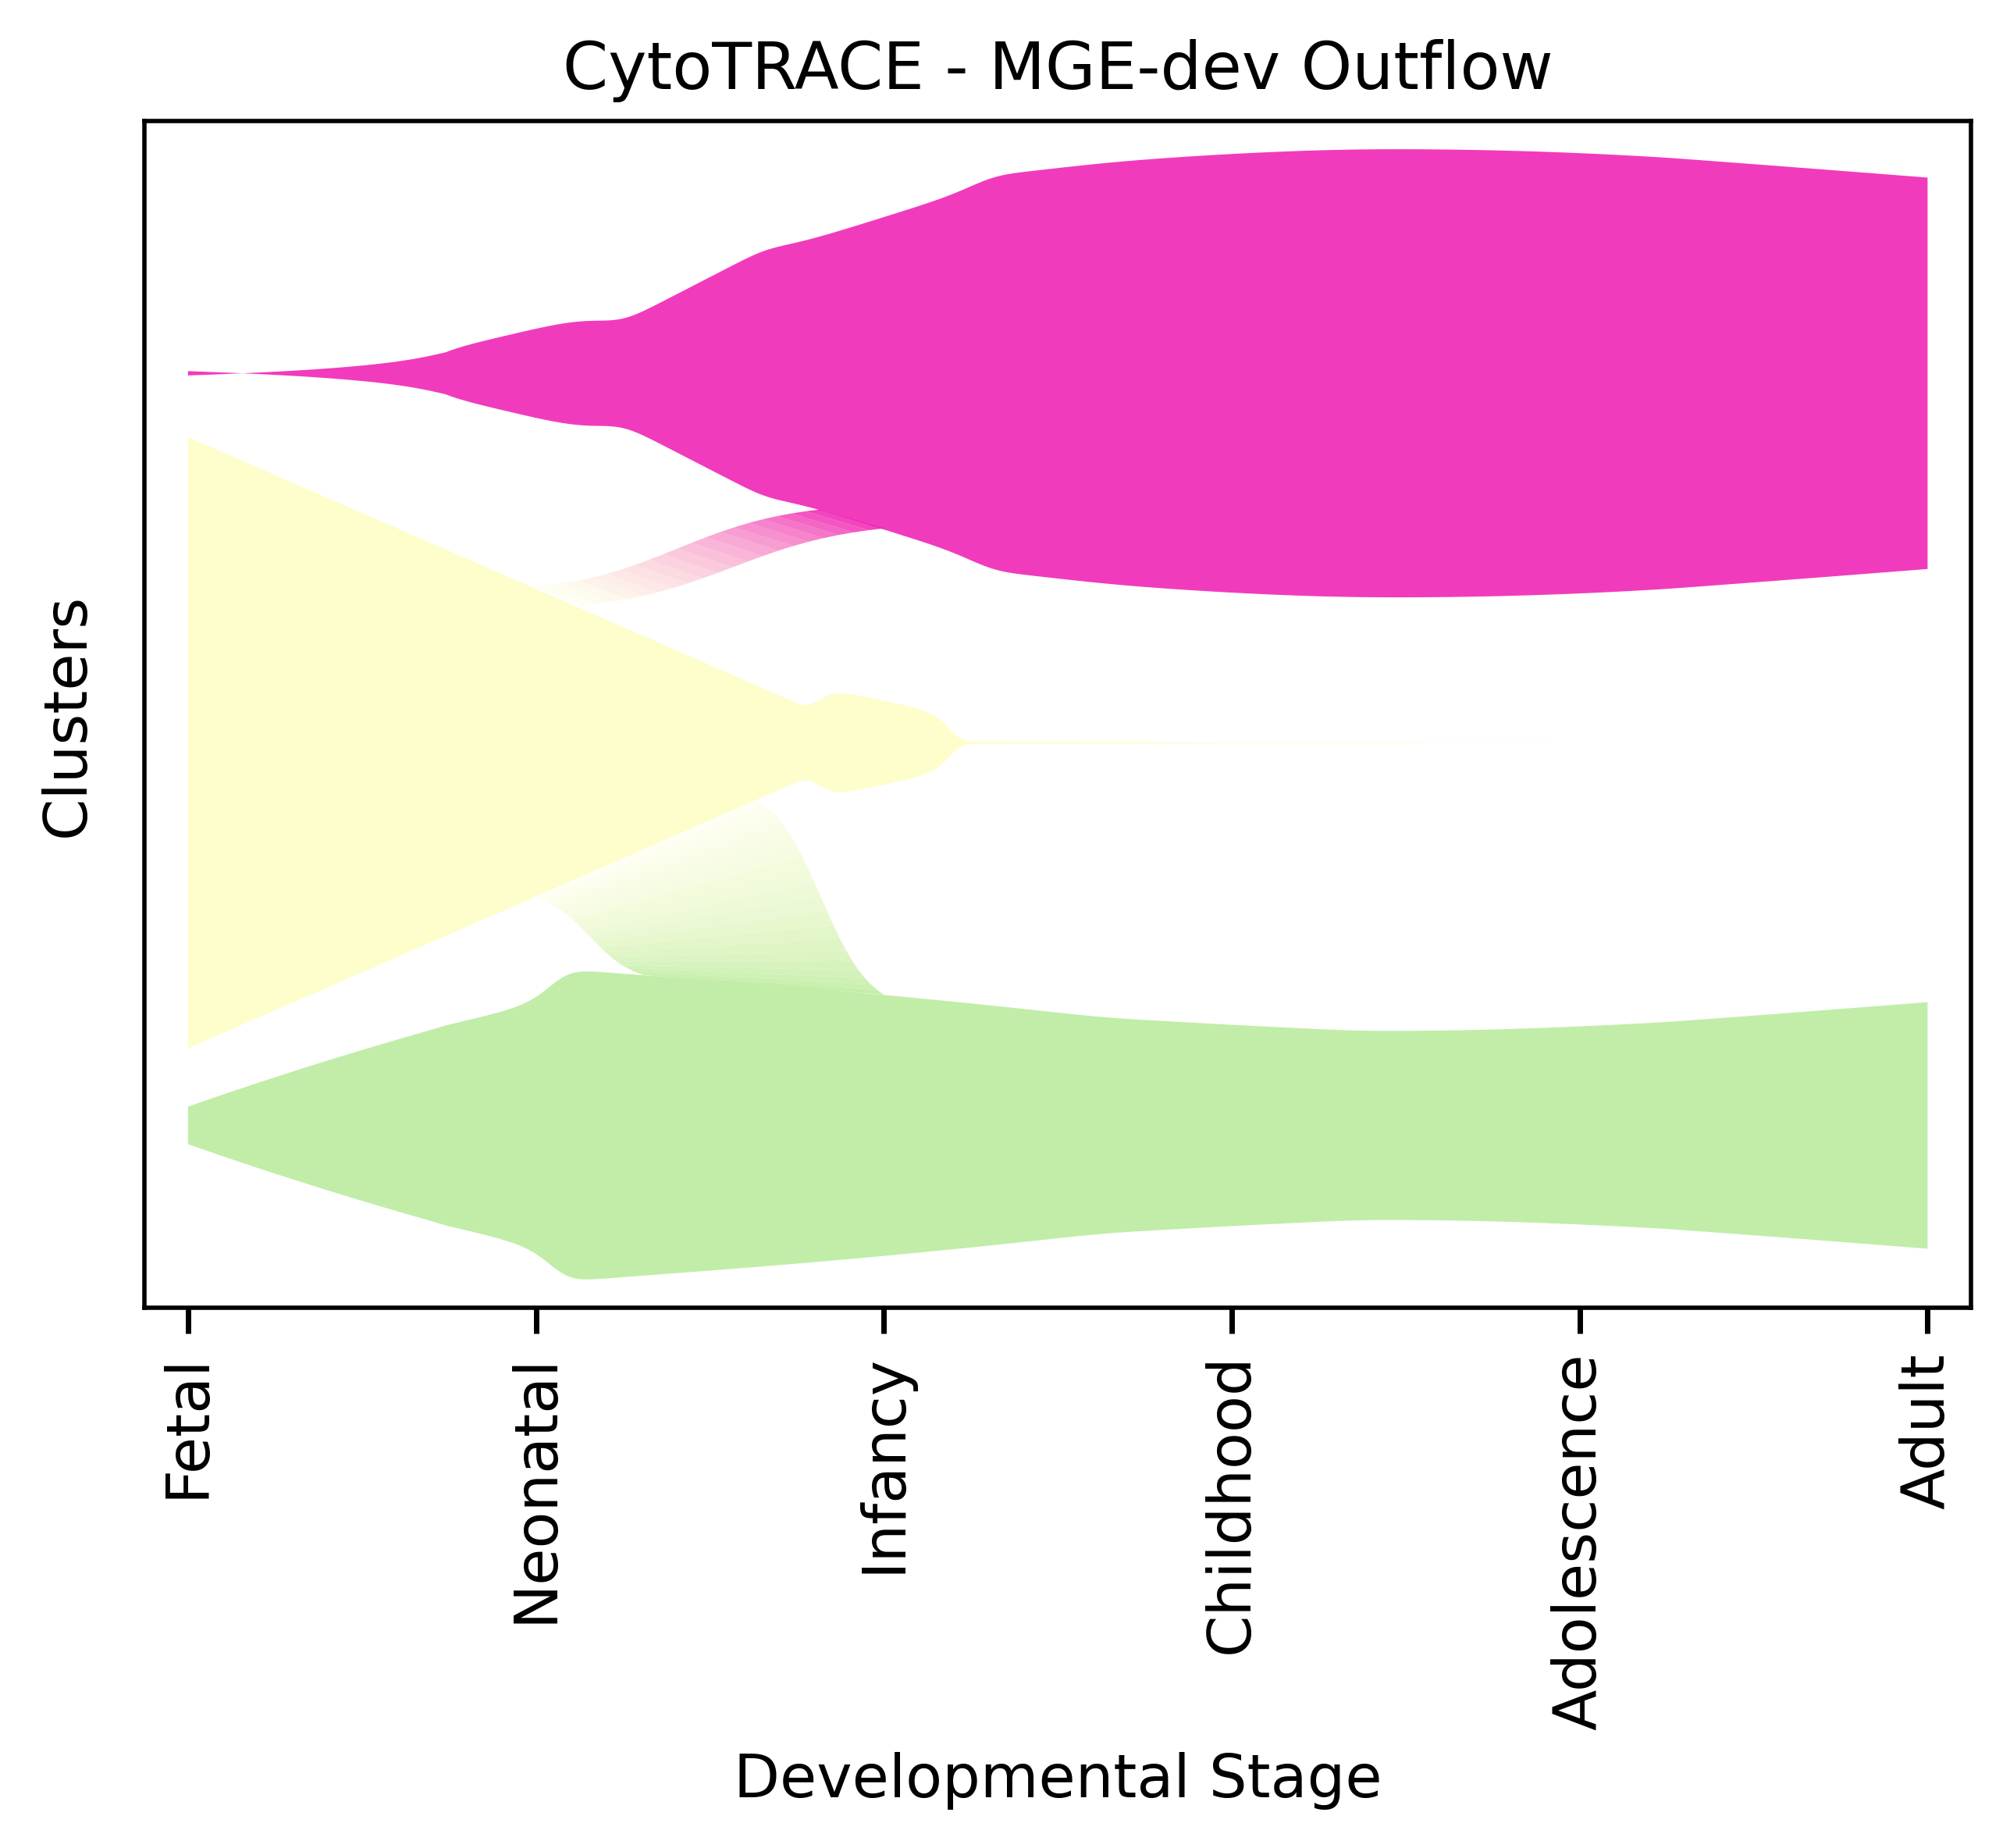

In [29]:
ax = ctk.plot_single_flow(
    cluster_key="sub_clust",
    time_key="stage_num",
    cluster="MGE_dev",
    min_flow=0.05,
    xticks_step_size=1,
    show=False,
    dpi=250,
    clusters=["LAMP5_NOS1", "LAMP5_CCK"],
    legend_loc=None
)

# prettify the plot a bit, rotate x-axis tick labels
locs, labels = plt.xticks()
ax.set_title('CytoTRACE - MGE-dev Outflow')
ax.set_ylabel( 'Clusters')
ax.set_xlabel( 'Developmental Stage')
ax.set_xticks(locs)
ax.set_xticklabels(stage_order, rotation=90);

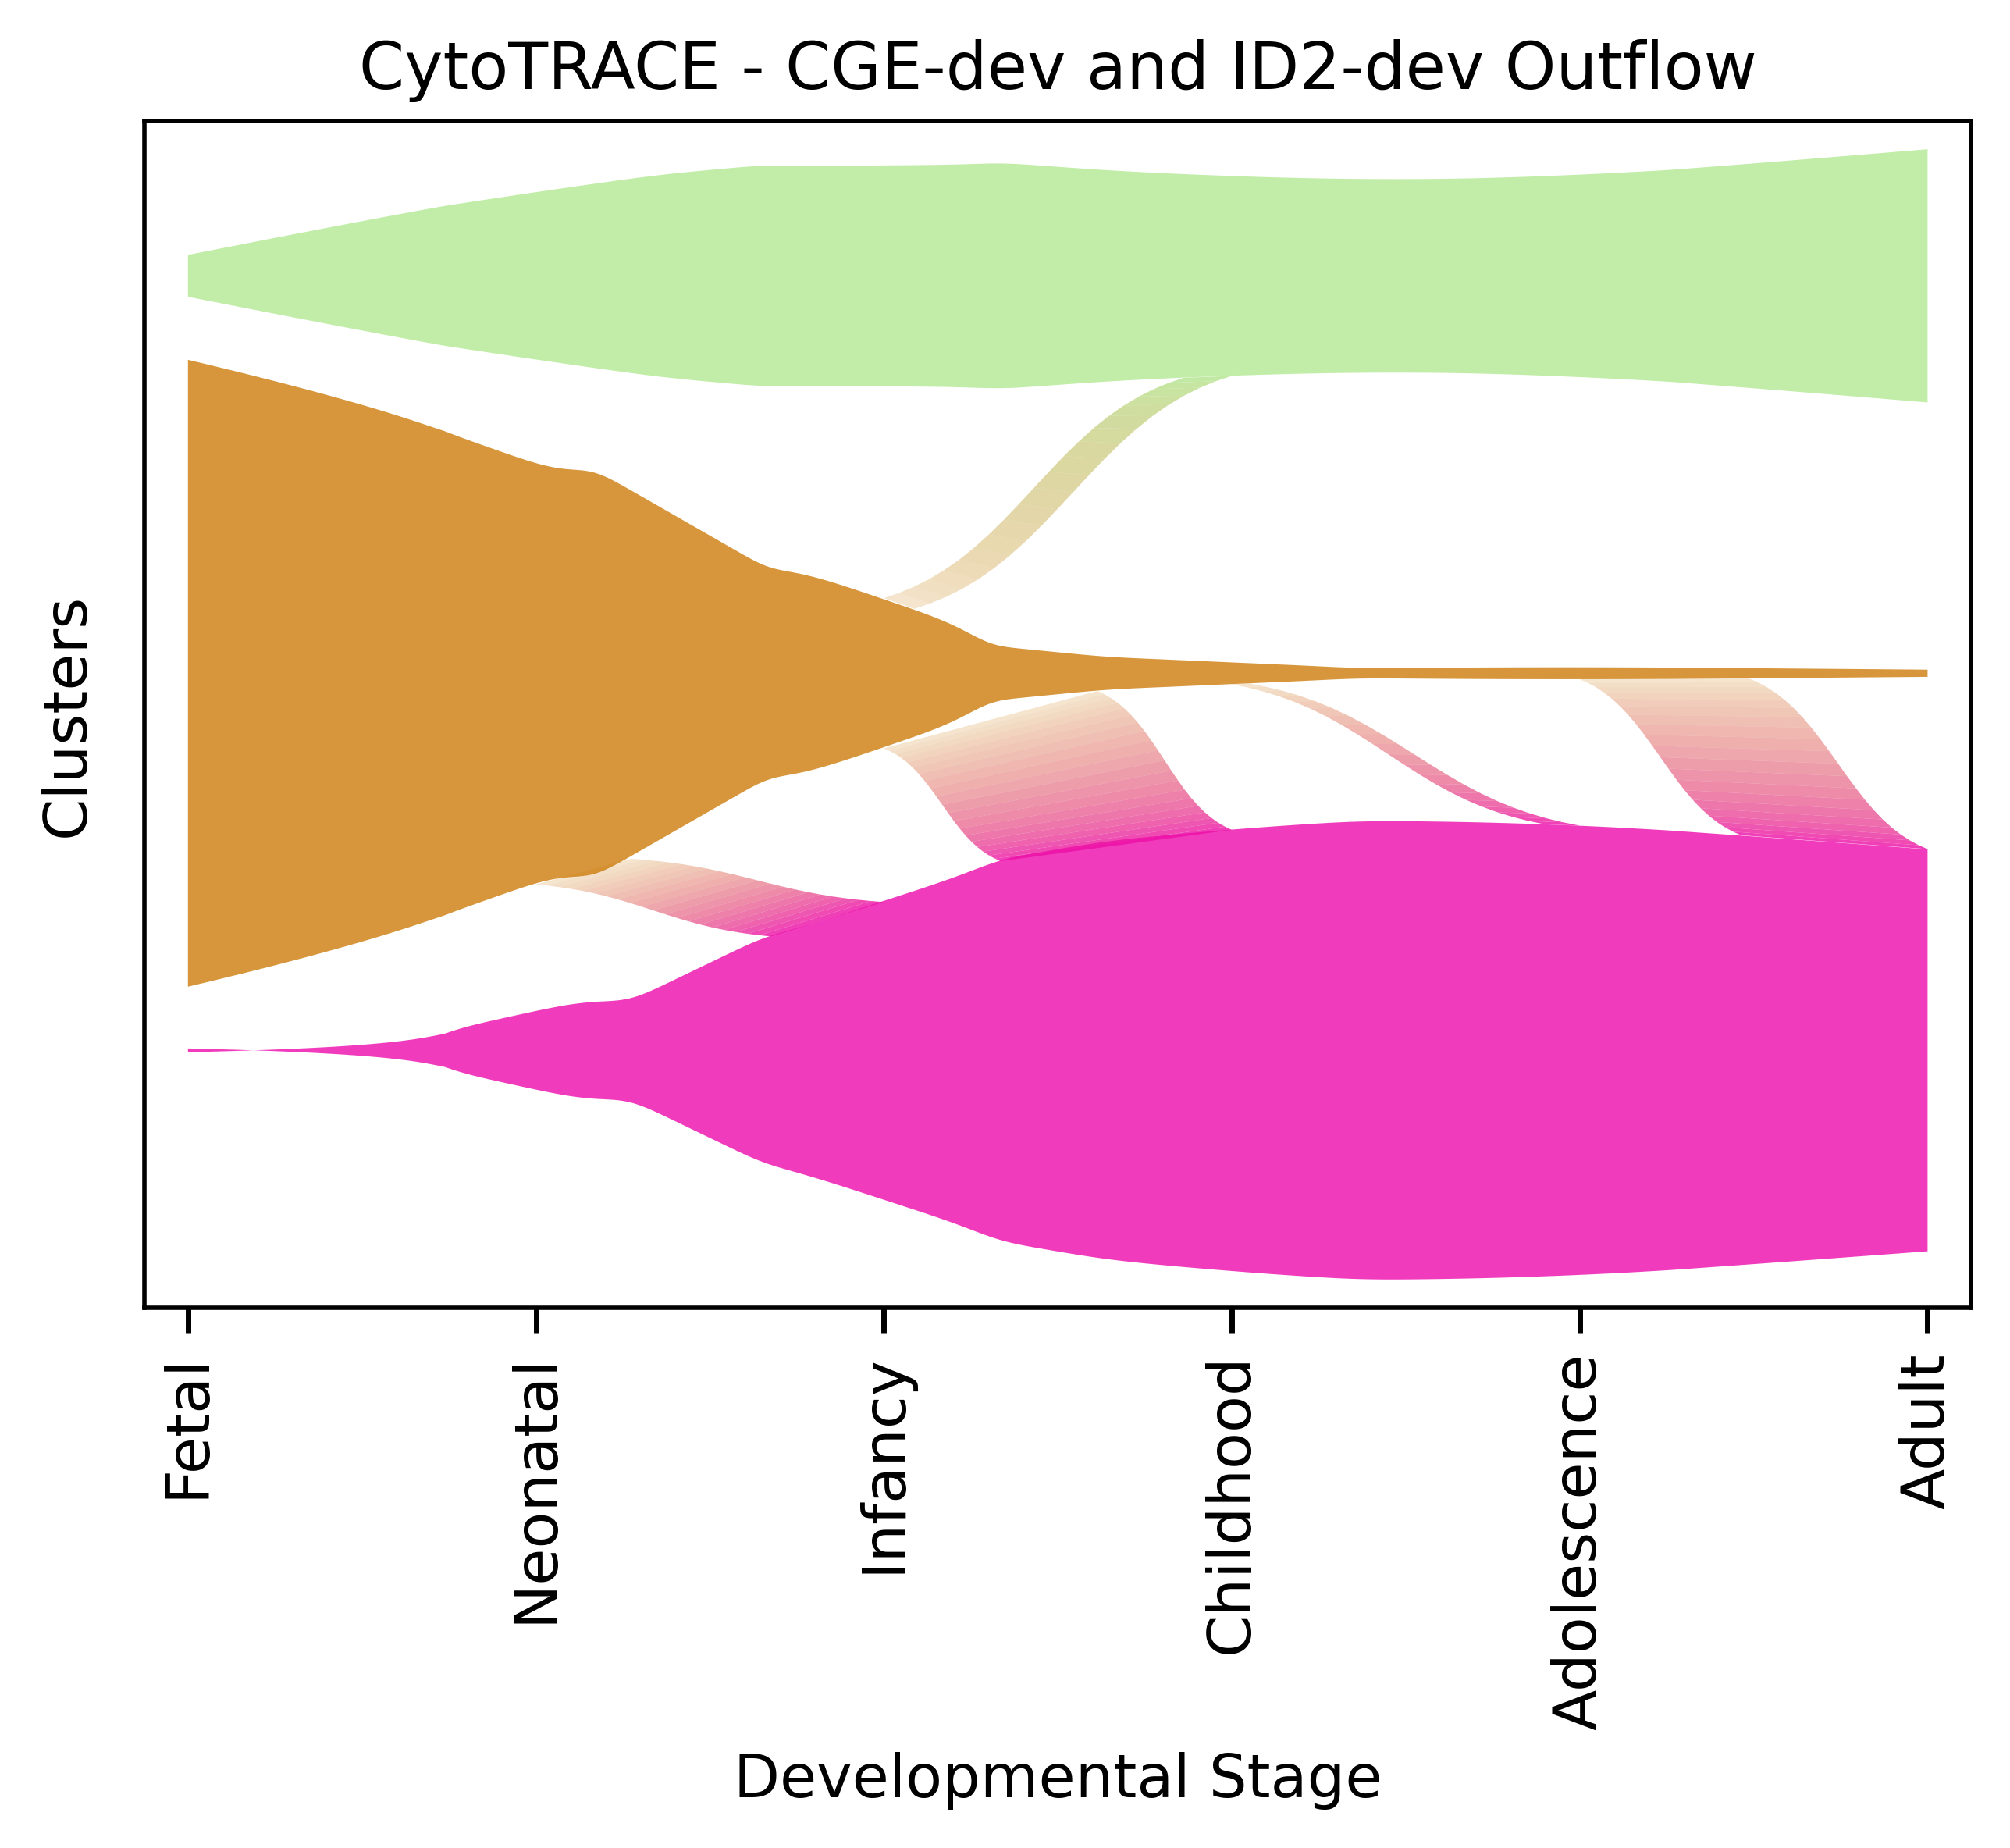

In [30]:
ax = ctk.plot_single_flow(
    cluster_key="sub_clust",
    time_key="stage_num",
    cluster="CGE_ID2_dev",
    min_flow=0.05,
    xticks_step_size=1,
    show=False,
    dpi=250,
    clusters=["LAMP5_NOS1", "LAMP5_CCK"],
    legend_loc=None
)

# prettify the plot a bit, rotate x-axis tick labels
locs, labels = plt.xticks()
ax.set_title('CytoTRACE - CGE-dev and ID2-dev Outflow')
ax.set_ylabel( 'Clusters')
ax.set_xlabel( 'Developmental Stage')
ax.set_xticks(locs)
ax.set_xticklabels(stage_order, rotation=90);